In [1]:
%load_ext lab_black
import os, sys

%load_ext autoreload
%autoreload 2

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md
import submitit
import os
import pandas as pd
import numpy as np

sys.path.append("/n/home12/khou/holystore/")
import paper_utils

In [2]:
URL_SUPP_TABLE = "./supp_tables.xlsx"

df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

df_celltype_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=1,
)

In [3]:
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name="facs")
df_hom = pd.read_csv(
    "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/"
    "mouse_human_homologs.txt",
    sep="\t",
)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [4]:
brain_neuron_cells = data_facs_ct.obs.cell_ontology_class.str.contains("neuron")
heart_myocyte_cells = data_facs_ct.obs.cell_ontology_class.str.contains("myocyte") & (
    data_facs_ct.obs.tissue == "Heart"
)
marrow_monocyte_cells = data_facs_ct.obs.cell_ontology_class.str.contains(
    "monocyte"
) & (data_facs_ct.obs.tissue == "Marrow")

t_cells = data_facs_ct.obs.cell_ontology_class.str.contains("T cell")
hepatocyte_cells = data_facs_ct.obs.cell_ontology_class.str.contains("hepatocyte")


positive_pairs = {
    "PASS_Schizophrenia_Pardinas2018": data_facs_ct.obs.index[brain_neuron_cells],
    "PASS_MDD_Howard2019": data_facs_ct.obs.index[brain_neuron_cells],
    "PASS_AtrialFibrillation_Nielsen2018": data_facs_ct.obs.index[heart_myocyte_cells],
    "PASS_Rheumatoid_Arthritis": data_facs_ct.obs.index[t_cells],
    "UKB_460K.biochemistry_LDLdirect": data_facs_ct.obs.index[hepatocyte_cells],
}

negative_pairs = {
    "PASS_Schizophrenia_Pardinas2018": data_facs_ct.obs.index[t_cells],
    "PASS_MDD_Howard2019": data_facs_ct.obs.index[t_cells],
    "PASS_AtrialFibrillation_Nielsen2018": data_facs_ct.obs.index[brain_neuron_cells],
    "PASS_Rheumatoid_Arthritis": data_facs_ct.obs.index[hepatocyte_cells],
    "UKB_460K.biochemistry_LDLdirect": data_facs_ct.obs.index[brain_neuron_cells],
}
list_trait = list(positive_pairs.keys())
dict_control_pairs = {
    trait: [positive_pairs[trait], negative_pairs[trait]] for trait in positive_pairs
}

In [5]:
list_gs_name = [
    f"{window_size}kb.{n_gene}"
    for window_size in [10]
    for n_gene in [100, 500, 1000, 2000]
] + [f"{window_size}kb.{n_gene}" for window_size in [0, 50] for n_gene in [1000]]

dict_score_df = {gs_name: [] for gs_name in list_gs_name}
for trait in np.unique(list(positive_pairs.keys()) + list(negative_pairs.keys())):
    for gs_name in list_gs_name:
        df_temp = pd.read_csv(
            f"00_calc_score/tms_facs/score_file/{gs_name}/{trait}.score.gz",
            sep="\t",
            index_col=0,
        )
        dict_score_df[gs_name].append(
            df_temp[["zscore"]].rename(columns={"zscore": trait})
        )

for gs_name in dict_score_df:
    dict_score_df[gs_name] = pd.concat(dict_score_df[gs_name], axis=1)

In [6]:
from scipy.stats import ttest_ind

df_t_stat = pd.DataFrame(index=list_trait, columns=list_gs_name, dtype=float)

for gs_name in list_gs_name:
    for trait in list_trait:
        df_score = dict_score_df[gs_name]
        positive_cells = df_score[trait].index.isin(dict_control_pairs[trait][0])
        negative_cells = df_score[trait].index.isin(dict_control_pairs[trait][1])

        df_t_stat.loc[trait, gs_name] = ttest_ind(
            df_score[trait][positive_cells],
            df_score[trait][negative_cells],
            equal_var=False,
        )[0]

In [7]:
df_t_stat.mean(axis=0).sort_values()

10kb.100     57.955995
0kb.1000     62.575338
10kb.2000    65.826787
10kb.500     66.465757
10kb.1000    67.226488
50kb.1000    68.808424
dtype: float64

In [8]:
df_trait_info

,Trait Name,Trait_Identifier,Code,Category,Reference,N,M,h2g,sd,Z,Intercept
0,Crohn's Disease,PASS_CD_deLange2017,CD,blood/immune,de Lange et al. 2017 Nat Genet,40266.0,1150097,0.4152,0.0361,11.501385,1.1010
1,Celiac Disease,PASS_Celiac,Celiac,blood/immune,"Dubois et al., 2010 Nat Genet",15283.0,245449,0.3296,0.0697,4.728838,1.0528
2,Inflammatory Bowel Disease,PASS_IBD_deLange2017,IBD,blood/immune,de Lange et al. 2017 Nat Genet,59957.0,1150510,0.3206,0.0243,13.193416,1.1216
3,Systemic Lupus Erythematosus,PASS_Lupus,SLE,blood/immune,"Bentham et al., 2015 Nat Genet",14267.0,654940,0.4584,0.0957,4.789969,1.0899
4,Multiple Sclerosis,PASS_Multiple_sclerosis,MS,blood/immune,"IMS Genetics Consortium, 2011 Nature",27148.0,227549,0.0812,0.0373,2.176944,1.0416
...,...,...,...,...,...,...,...,...,...,...,...
69,FEV1-FVC Ratio,UKB_460K.lung_FEV1FVCzSMOKE,FEV1/FVC,other,UK Biobank,371949.0,1187057,0.2763,0.0117,23.615385,1.1129
70,Forced Vital Capacity (FVC),UKB_460K.lung_FVCzSMOKE,FVC,other,UK Biobank,371949.0,1187057,0.2336,0.0072,32.444444,1.1046
71,Hair Color,UKB_460K.pigment_HAIR,Hair color,other,UK Biobank,452720.0,1187057,0.1658,0.0211,7.857820,1.2280
72,Age at Menarche,UKB_460K.repro_MENARCHE_AGE,MNR,other,UK Biobank,242278.0,1187057,0.2530,0.0103,24.563107,1.0607


In [9]:
trait_name_dict = {
    row["Trait_Identifier"]: row["Trait Name"] for _, row in df_trait_info.iterrows()
}
df_t_stat.rename(index=trait_name_dict).round(1)

,10kb.100,10kb.500,10kb.1000,10kb.2000,0kb.1000,50kb.1000
Schizophrenia,30.0,47.8,54.3,60.4,56.7,52.8
Major Depressive Disorder,40.5,47.4,52.4,53.1,52.0,51.9
Atrial Fibrillation,33.5,24.7,25.3,21.7,24.2,23.4
Rheumatoid Arthritis,124.4,120.8,133.1,117.2,108.3,137.8
LDLdirect,61.4,91.7,71.0,76.8,71.7,78.2


# Relationship between parameter to optimize power and polygenicity of traits
1. Load the dataframe of scDRS scores for every gene sets and trait
2. Calculate the power for each gene sets and traits

In [10]:
from os.path import join
from statsmodels.stats.multitest import multipletests

In [11]:
dict_score_df = dict()
for param in ["10kb.100", "10kb.500", "10kb.1000", "10kb.2000"]:
    SCORE_PATH = f"00_calc_score/tms_facs/score_file/{param}/"
    dict_df = dict()
    for trait in df_trait_info["Trait_Identifier"].values:
        df_temp = pd.read_csv(
            join(SCORE_PATH, f"{trait}.score.gz"), sep="\t", index_col=0
        )
        dict_df[trait] = df_temp["zscore"]
    df_trs_zsc = pd.DataFrame(dict_df)
    dict_score_df[param] = df_trs_zsc

In [12]:
dict_fdr_prop = dict()

for gs_name in dict_score_df:
    df_fdr = dict_score_df[gs_name].transform(
        lambda x: multipletests(paper_utils.zsc2pval(x), method="fdr_bh")[1]
    )
    dict_fdr_prop[gs_name] = np.mean(df_fdr < 0.1, axis=0)

In [13]:
dict_df_power = {}
dict_optim_n_gene = {}
df_power = pd.DataFrame(dict_fdr_prop)
df_power = df_power[[col for col in df_power.columns if col.startswith("10kb")]].rename(
    columns=lambda x: int(x.split(".")[-1])
)
dict_optim_n_gene = df_power.idxmax(axis=1).to_dict()

In [14]:
dict_trait_name = {
    row.Trait_Identifier: row["Trait Name"] for _, row in df_trait_info.iterrows()
}

In [15]:
df_polygenicity = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name="oconnor-polygenicity",
)
dict_polygenicity = {
    row[0]: float(row[1].split(" ")[0])
    for _, row in df_polygenicity.iloc[:, [0, 2]].dropna().iterrows()
    if row[0] in dict_trait_name
}
df_trait_h2 = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)
dict_trait_h2 = {
    row["Trait_Identifier"]: row["h2g"] for _, row in df_trait_h2.iterrows()
}


def as_si(x, ndp):
    s = "{x:0.{ndp:d}e}".format(x=x, ndp=ndp)
    m, e = s.split("e")
    return r"{m:s}\times 10^{{{e:d}}}".format(m=m, e=int(e))

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from os.path import join

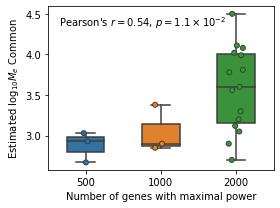

In [17]:
df_compare = {"trait": [], "optim_n_gene": [], "polygenicity": [], "h2g": []}
for trait in dict_polygenicity:
    df_compare["trait"].append(trait)
    df_compare["optim_n_gene"].append(dict_optim_n_gene[trait])
    df_compare["polygenicity"].append(dict_polygenicity[trait])
    df_compare["h2g"].append(dict_trait_h2[trait])

df_compare = pd.DataFrame(df_compare).set_index("trait")

fig, ax = plt.subplots(figsize=(4, 3))
sns.stripplot(
    x=df_compare["optim_n_gene"],
    y=df_compare["polygenicity"],
    jitter=True,
    edgecolor="gray",
    linewidth=1,
    ax=ax,
)
sns.boxplot(
    x=df_compare["optim_n_gene"], y=df_compare["polygenicity"], width=0.5, ax=ax
)

r, p = pearsonr(df_compare["optim_n_gene"], df_compare["polygenicity"])

ax.text(
    0.05,
    0.9,
    f"Pearson's $r = {r:.2f}$, $p={as_si(p, 1)}$",
    ha="left",
    va="center",
    fontsize=10,
    transform=ax.transAxes,
)

plt.xlabel("Number of genes with maximal power")
plt.ylabel("Estimated $\log_{10} M_e$ Common")
plt.tight_layout()

plt.savefig(f"results/geneset_polygenic.pdf", bbox_inches="tight")
plt.show()

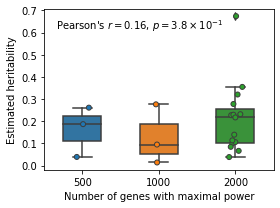

In [18]:
df_compare = {"trait": [], "optim_n_gene": [], "polygenicity": [], "h2g": []}
for trait in dict_polygenicity:
    df_compare["trait"].append(trait)
    df_compare["optim_n_gene"].append(dict_optim_n_gene[trait])
    df_compare["polygenicity"].append(dict_polygenicity[trait])
    df_compare["h2g"].append(dict_trait_h2[trait])

df_compare = pd.DataFrame(df_compare).set_index("trait")

fig, ax = plt.subplots(figsize=(4, 3))

sns.stripplot(
    x=df_compare["optim_n_gene"],
    y=df_compare["h2g"],
    jitter=True,
    edgecolor="gray",
    linewidth=1,
    ax=ax,
)
sns.boxplot(x=df_compare["optim_n_gene"], y=df_compare["h2g"], width=0.5, ax=ax)

r, p = kendalltau(df_compare["optim_n_gene"], df_compare["h2g"])

ax.text(
    0.05,
    0.9,
    f"Pearson's $r = {r:.2f}$, $p={as_si(p, 1)}$",
    ha="left",
    va="center",
    fontsize=10,
    transform=ax.transAxes,
)

plt.xlabel("Number of genes with maximal power")
plt.ylabel("Estimated heritability")
plt.tight_layout()
plt.savefig(f"results/geneset_h2.pdf", bbox_inches="tight")
plt.show()